In [106]:
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np

In [107]:
template_dir = 'templates'
templates = {}

for template_file in os.listdir(template_dir):
    if template_file.endswith('.jpg'):
        template_name = template_file.split('.')[0]
        template_path = os.path.join(template_dir, template_file)
        templates[template_name] = cv2.imread(template_path)

def match_template(card_image, template_image):
    # Convert the template to grayscale (if needed)
    template_gray = cv2.cvtColor(template_image, cv2.COLOR_BGR2GRAY)
    
    # Apply template matching
    result = cv2.matchTemplate(card_image, template_gray, cv2.TM_CCOEFF_NORMED)
    
    # Get the best match position
    _, max_val, _, max_loc = cv2.minMaxLoc(result)
    
    return round(max_val, 4), max_loc

In [108]:
def imshow(img, ax=None, cmap='gray'):
    if ax is None:
        plt.figure(figsize=(10, 10))
        ax = plt
    ax.imshow(img, cmap=cmap)
    ax.axis('off')

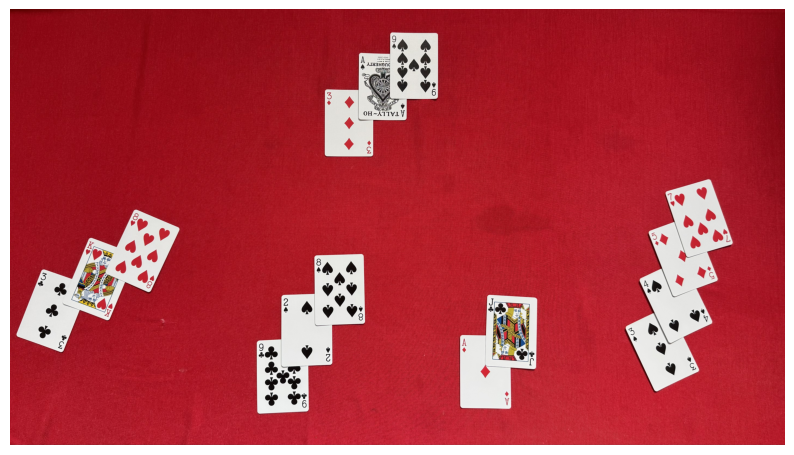

In [109]:
image_path = "database/IMG_2540.jpeg"  # Path to your uploaded image
image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
imshow(image, cmap=None)

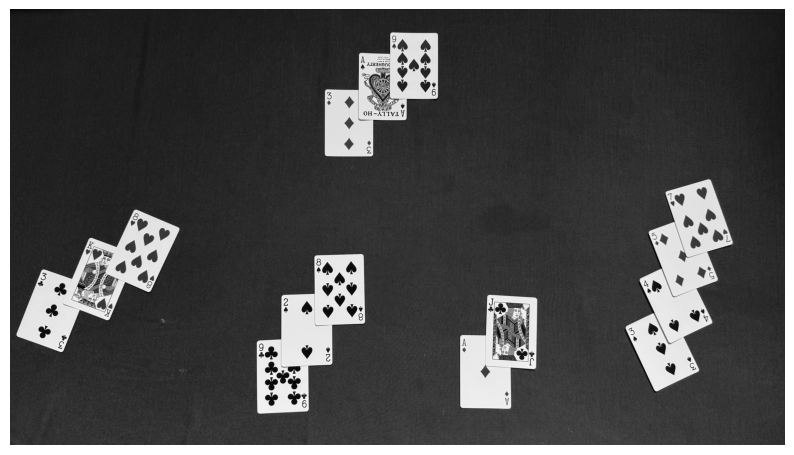

In [110]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
imshow(gray)

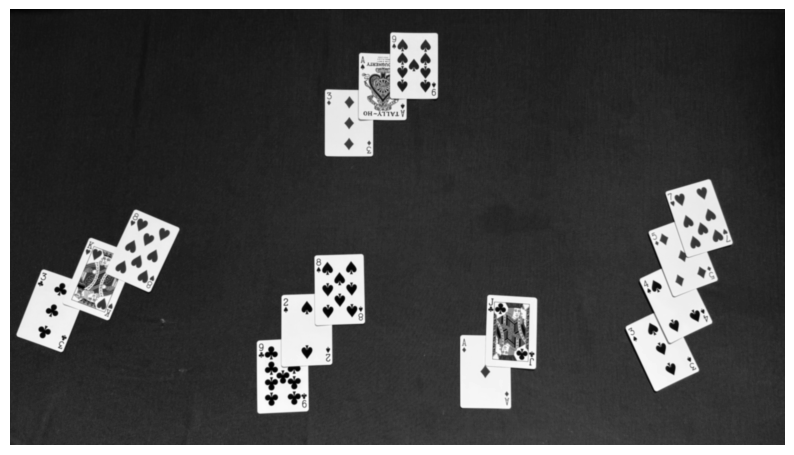

In [111]:
blur = cv2.GaussianBlur(gray, (21, 21), 0)
imshow(blur)

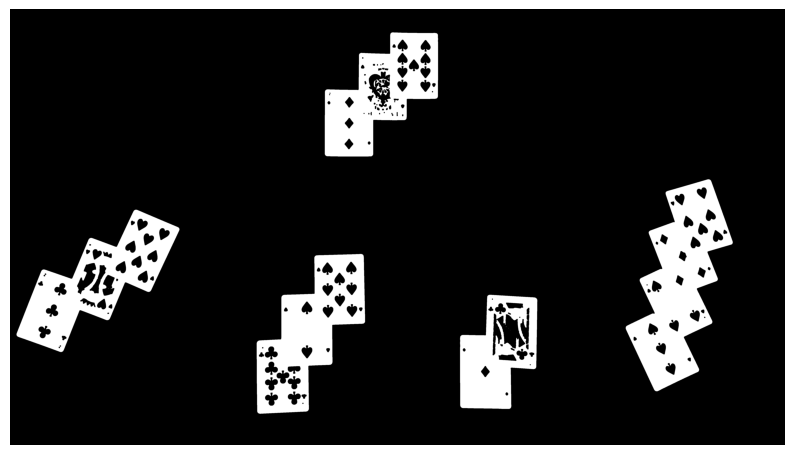

In [112]:
_, thresh = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, np.ones((7, 7)))
imshow(thresh)

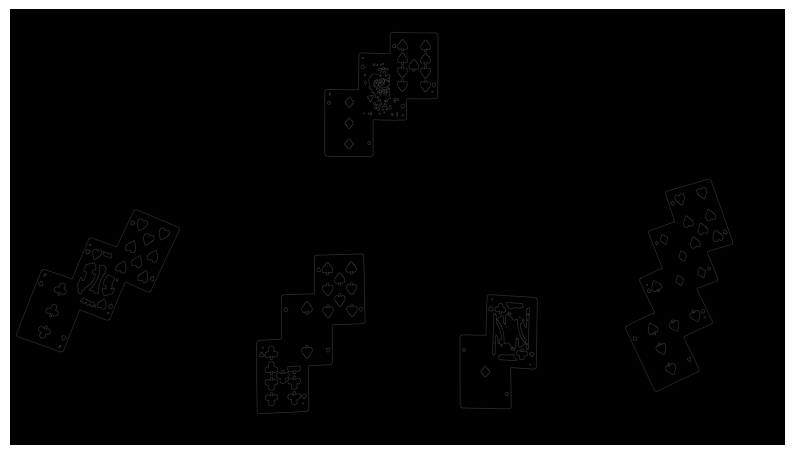

In [113]:
edges = cv2.Canny(thresh, 50, 150)
imshow(edges)

In [114]:
contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]
threshold_min_area = 50_000
number_of_contours = 0

bounding_rects = []

image_with_piles = image.copy()

for c in contours:
    area = cv2.contourArea(c)
    if area > threshold_min_area:
        cv2.drawContours(image_with_piles, [c], 0, (0, 255, 0), 22)
        number_of_contours += 1
        
        bounding_rects.append((*cv2.boundingRect(c), c))

Contours detected: 5


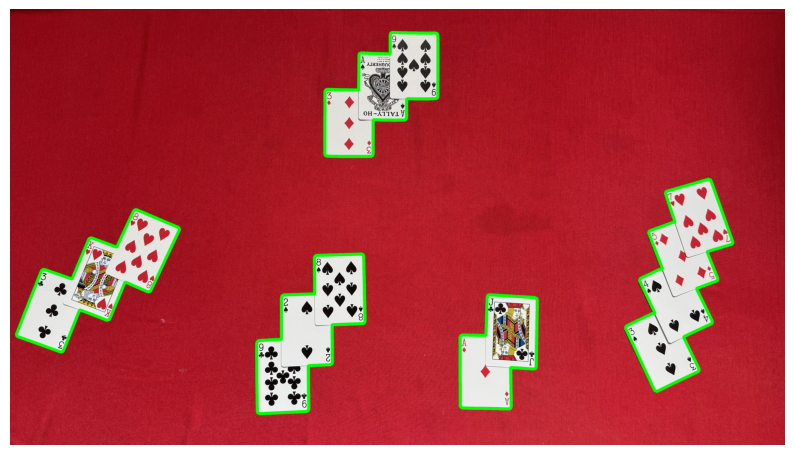

In [115]:
print("Contours detected:", number_of_contours)
imshow(image_with_piles)

In [116]:
def get_cropped_pile_image(image, bounding_rect):
    x, y, w, h, c = bounding_rect
    
    mask = np.zeros_like(image)
    cv2.drawContours(mask, [c], -1, (255, 255, 255), thickness=cv2.FILLED)
    masked_image = cv2.bitwise_and(image, mask)
    cropped_image = masked_image[y:y+h, x:x+w]
    
    return cropped_image

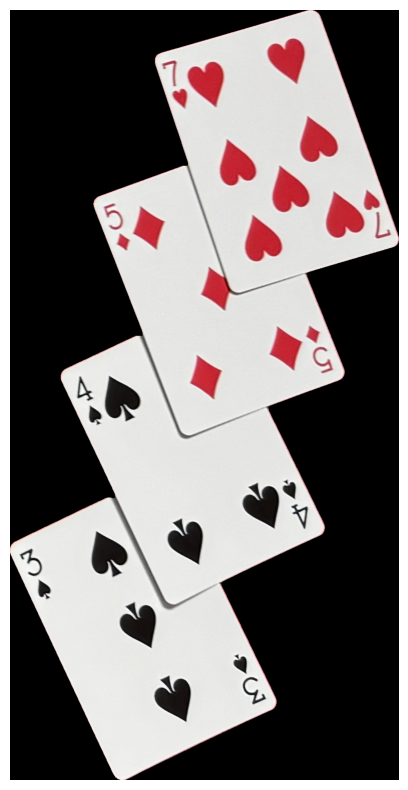

In [117]:
cropped_pile = get_cropped_pile_image(image, bounding_rects[3])
X, Y, _, _, _ = bounding_rects[3]
imshow(cropped_pile)

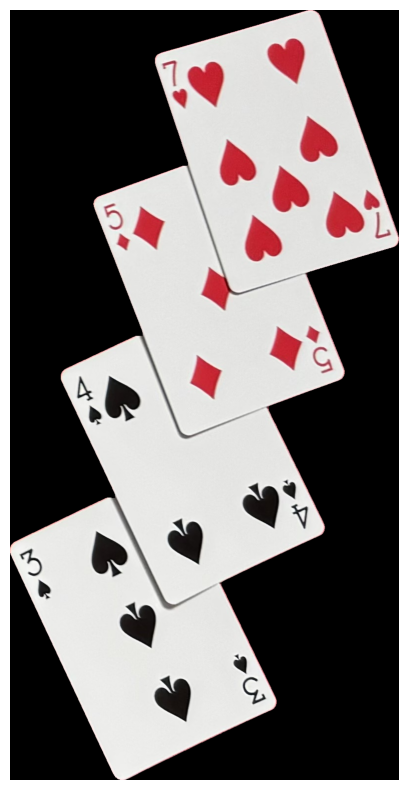

In [118]:
normalized = cv2.normalize(cropped_pile, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
imshow(normalized)

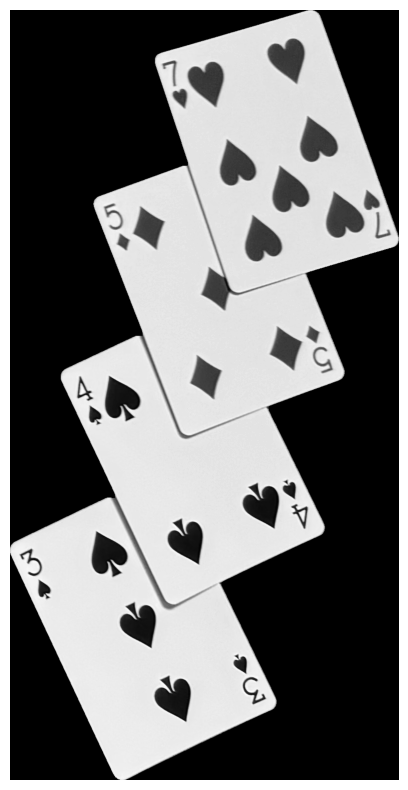

In [119]:
cropped_grey = cv2.cvtColor(cropped_pile, cv2.COLOR_BGR2GRAY)
imshow(cropped_grey)

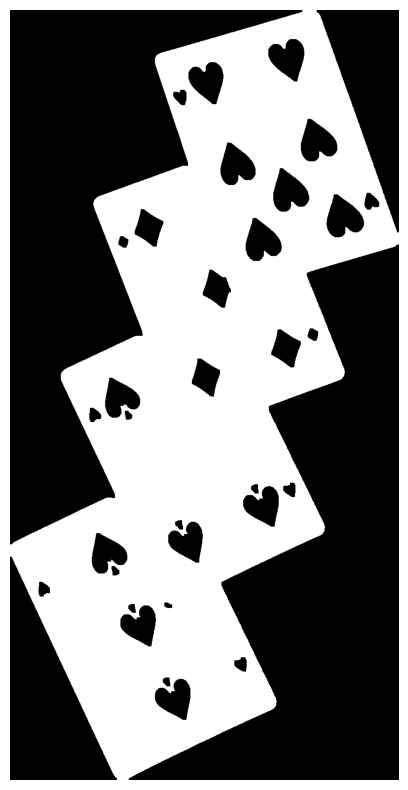

In [120]:
_, cropped_thresh = cv2.threshold(cropped_grey,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
cropped_thresh = cv2.morphologyEx(cropped_thresh, cv2.MORPH_CLOSE, np.ones((7, 7)))
imshow(cropped_thresh)

In [121]:
def line_intersection(point_1_a, point_1_b, point_2_a, point_2_b):
    """
    Find the intersection point of two lines passing through the given points.
    
    Parameters:
        point_1_a, point_1_b: Arrays representing two points on the first line.
        point_2_a, point_2_b: Arrays representing two points on the second line.
        
    Returns:
        A tuple representing the intersection point, or None if the lines are parallel.
    """
    # Convert points to numpy arrays
    p1, p2 = np.array(point_1_a), np.array(point_1_b)
    q1, q2 = np.array(point_2_a), np.array(point_2_b)
    
    # Direction vectors of the lines
    d1 = p2 - p1
    d2 = q2 - q1

    # Matrix A and vector b
    A = np.array([[d1[0], -d2[0]], [d1[1], -d2[1]]])
    b = np.array([q1[0] - p1[0], q1[1] - p1[1]])

    # Check if lines are parallel
    if np.linalg.det(A) == 0:
        return None  # Lines are parallel or coincident

    # Solve for intersection point
    t, s = np.linalg.solve(A, b)
    intersection = p1 + t * d1
    return tuple(intersection)

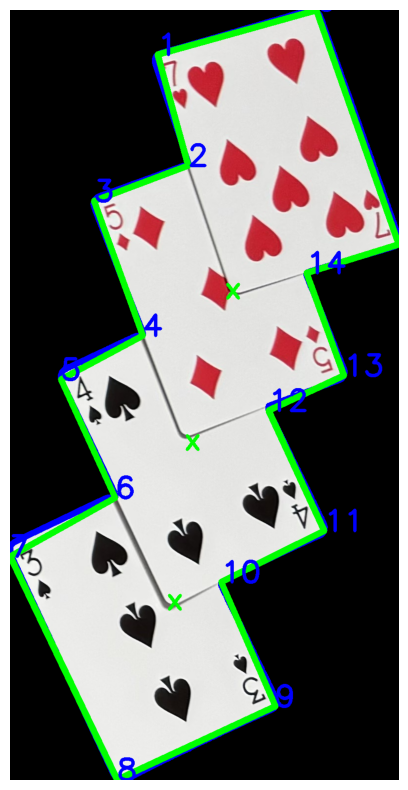

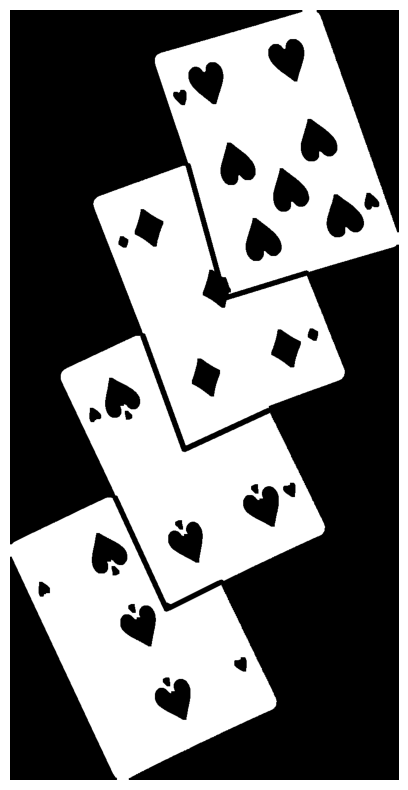

In [122]:
import einops

contours, _ = cv2.findContours(cropped_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)
contour = contours[0]

cv2.drawContours(cropped_pile, [contour], -1, (0, 0, 255), thickness=11)

epsilon = 0.01 * cv2.arcLength(contour, True)
approx = cv2.approxPolyDP(contour, epsilon, True)

cv2.drawContours(cropped_pile, [approx], -1, (0, 255, 0), thickness=11)

points = np.array(approx)
points = einops.rearrange(points, 'n_points 1 coords -> n_points coords')

for i, point in enumerate(points):
    cv2.putText(cropped_pile, f'{i}', point, 0, 2., (0, 0, 255), 5)
    pass
    
for i in range(1, len(points) // 2 - 1, 2):
    point_1_a = points[i]
    point_1_b = points[i + 1]
    point_2_a = points[len(points) - i]
    point_2_b = points[len(points) - i - 1]
    
    intersection = np.round(line_intersection(point_1_a, point_1_b, point_2_a, point_2_b)).astype(np.int32) 
    cv2.putText(cropped_pile, f'x', intersection, 0, 2., (0, 255, 0), 5)
    
    cv2.line(cropped_thresh, point_1_b, intersection, color=(0, 0, 0), thickness=10)
    cv2.line(cropped_thresh, point_2_b, intersection, color=(0, 0, 0), thickness=10)

imshow(cropped_pile)
imshow(cropped_thresh)

In [123]:
def flattener(image, pts, w, h):
    """Flattens an image of a card into a top-down 200x300 perspective.
    Returns the flattened, re-sized, grayed image.
    See www.pyimagesearch.com/2014/08/25/4-point-opencv-getperspective-transform-example/"""
    temp_rect = np.zeros((4, 2), dtype="float32")

    s = np.sum(pts, axis=2)

    tl = pts[np.argmin(s)]
    br = pts[np.argmax(s)]

    diff = np.diff(pts, axis=-1)
    tr = pts[np.argmin(diff)]
    bl = pts[np.argmax(diff)]

    # Need to create an array listing points in order of
    # [top left, top right, bottom right, bottom left]
    # before doing the perspective transform

    if w <= 0.8 * h:  # If card is vertically oriented
        temp_rect[0] = tl
        temp_rect[1] = tr
        temp_rect[2] = br
        temp_rect[3] = bl

    if w >= 1.2 * h:  # If card is horizontally oriented
        temp_rect[0] = bl
        temp_rect[1] = tl
        temp_rect[2] = tr
        temp_rect[3] = br

    # If the card is 'diamond' oriented, a different algorithm
    # has to be used to identify which point is top left, top right
    # bottom left, and bottom right.

    if w > 0.8 * h and w < 1.2 * h:  # If card is diamond oriented
        # If furthest left point is higher than furthest right point,
        # card is tilted to the left.
        if pts[1][0][1] <= pts[3][0][1]:
            # If card is titled to the left, approxPolyDP returns points
            # in this order: top right, top left, bottom left, bottom right
            temp_rect[0] = pts[1][0]  # Top left
            temp_rect[1] = pts[0][0]  # Top right
            temp_rect[2] = pts[3][0]  # Bottom right
            temp_rect[3] = pts[2][0]  # Bottom left

        # If furthest left point is lower than furthest right point,
        # card is tilted to the right
        if pts[1][0][1] > pts[3][0][1]:
            # If card is titled to the right, approxPolyDP returns points
            # in this order: top left, bottom left, bottom right, top right
            temp_rect[0] = pts[0][0]  # Top left
            temp_rect[1] = pts[3][0]  # Top right
            temp_rect[2] = pts[2][0]  # Bottom right
            temp_rect[3] = pts[1][0]  # Bottom left

    maxWidth = 200
    maxHeight = 300

    # Create destination array, calculate perspective transform matrix,
    # and warp card image
    dst = np.array([[0, 0], [maxWidth - 1, 0], [maxWidth - 1, maxHeight - 1], [0, maxHeight - 1]], np.float32)
    M = cv2.getPerspectiveTransform(temp_rect, dst)
    warp = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    warp = cv2.cvtColor(warp, cv2.COLOR_BGR2GRAY)

    return warp

In [124]:
contours, _ = cv2.findContours(cropped_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)

flattened_cards = []

for contour in contours:
    epsilon = 0.02 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)

    if len(approx) >= 4:
        rect = cv2.minAreaRect(contour)
        box = cv2.boxPoints(rect)
        box = np.int32(box)
        
        area = cv2.contourArea(box)
        if area < 70_000:
            continue
            
        cv2.drawContours(image_with_piles, [box + [X, Y]], -1, (0, 0, 255), thickness=11)
            
        x, y, w, h = cv2.boundingRect(box)
            
        peri = cv2.arcLength(box,True)
        approx = cv2.approxPolyDP(box,0.01*peri,True)
        pts = np.float32(approx)

        flattened_card = flattener(cropped_pile, np.float32(approx), w, h)
        flattened_card = cv2.flip(flattened_card, 1)
        flattened_cards.append(flattened_card)

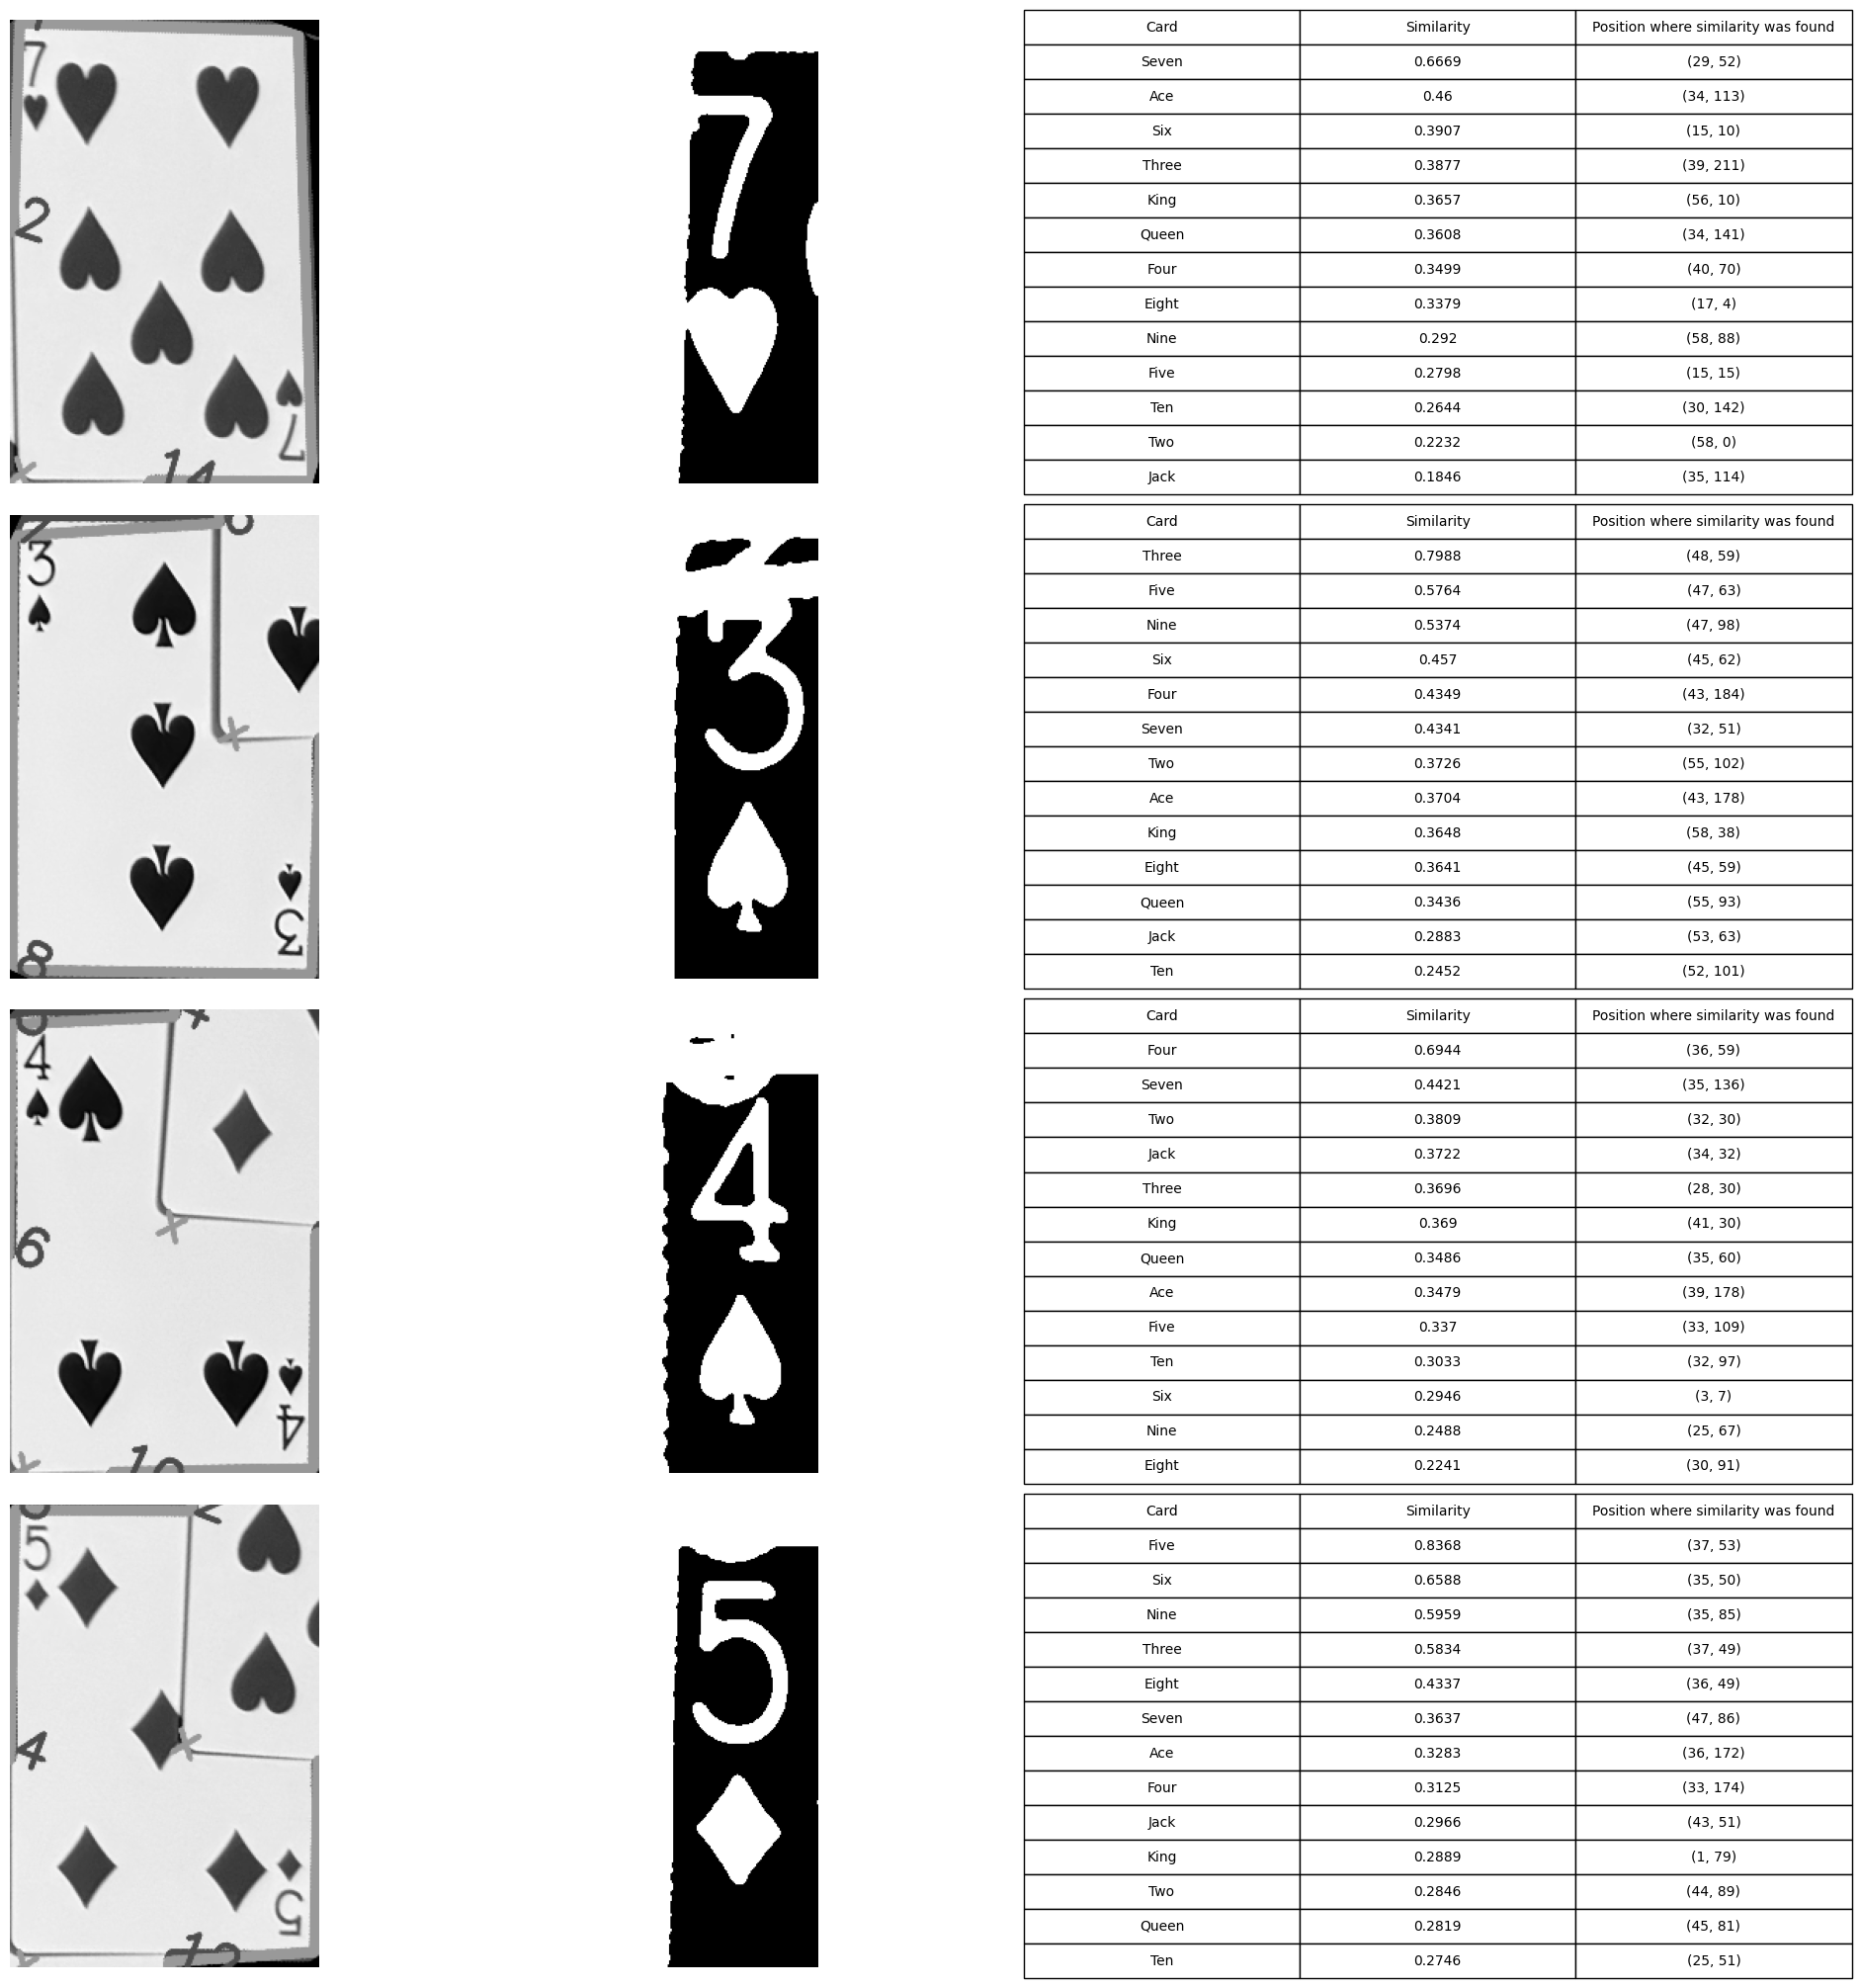

In [125]:
fig, axes = plt.subplots(len(flattened_cards), 3, figsize=(20, len(flattened_cards)*5), constrained_layout=True)

for i, grey_pile_image in enumerate(flattened_cards):
    corner = grey_pile_image[0:84, 0:32]
    corner_zoom = cv2.resize(corner, (0,0), fx=4, fy=4)
    corner_blur = cv2.GaussianBlur(corner_zoom,(5,5),0)
    retval, corner_thresh = cv2.threshold(corner_blur, 155, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    axes[i, 2].axis('off')
    text = sorted([[name, *match_template(corner_thresh, template)] for name, template in templates.items()], key=lambda x: x[1], reverse=True)
    
    table = axes[i, 2].table(
        colLabels=['Card', 'Similarity', 'Position where similarity was found'],
        cellText=text,
        cellLoc='center',
        rowLoc='center',
        loc='center'
    )
    
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.5, 1.5)
    
    imshow(corner_thresh, axes[i, 1])
    imshow(grey_pile_image, axes[i, 0])

# Display the plot
plt.show()

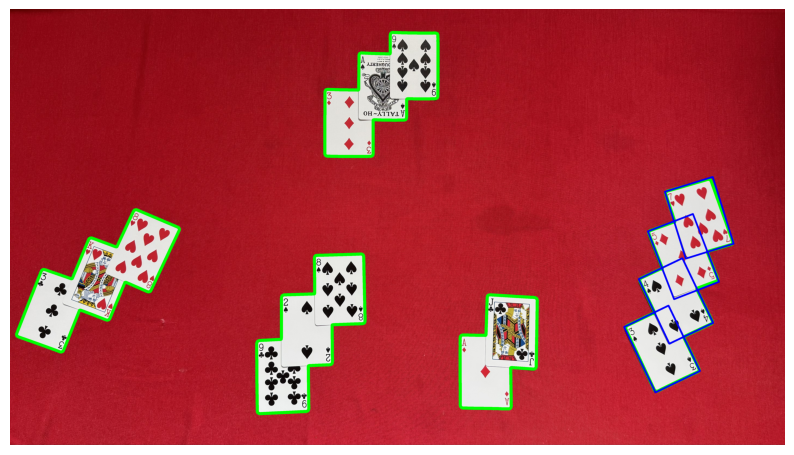

In [126]:
imshow(image_with_piles)